In [5]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [6]:
sns.set_palette('Set2')
%matplotlib inline

### Get data

In [433]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
# AUD train model时，会出现loss = NAN的情况。但是不知道为什么
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist = hist[hist.index>'2017-01-01']
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-01-02,1017.05,1031.68,990.20,995.44,64951.63,6.603807e+07
2017-01-03,1033.30,1035.47,1006.53,1017.05,54788.01,5.608587e+07
2017-01-04,1135.41,1148.54,1022.32,1033.30,156272.17,1.705846e+08
2017-01-05,989.35,1150.63,874.53,1135.41,240007.84,2.448393e+08
2017-01-06,886.16,1027.42,852.55,989.35,194290.96,1.791607e+08


In [434]:
# in case gradients explosion, some people suggest to drop some columns.
# hist = hist.drop(columns=['volumefrom'])
# hist.head()

In [435]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [436]:
# not stationary
testStationarity(hist['close'])

Test Statistic                  -1.971402
p-value                          0.299251
#Lags Used                      20.000000
Number of Observations Used    664.000000
Critical Value (1%)             -3.440237
Critical Value (5%)             -2.865903
Critical Value (10%)            -2.569093
dtype: float64

In [437]:
def difference(df):
    return df.diff(1).dropna()

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

For future reference: NaN loss could come from any value in your dataset that is not float or int. In my case, there were some NumPy infinities (np.inf), resulting from divide by zero in my program that prepares the dataset. Checking for inf or nan data first may save you some time spent trying to find faults in the model.

差分后的数据，可能会有0值。之后再进行标准的时候，就可能出现np.inf

In [438]:
def preprocess(df,test_size=0.2):
    df = difference(df)
    train_data, test_data = train_test_split(df, test_size)
    return train_data, test_data

In [439]:
train_data, test_data = preprocess(hist)

In [440]:
# 查找差分后数据中的0值
def deletzero(train):
    for i in range(train.shape[0]):
        for j in range(train.shape[1]):
            if train.iloc[i,j] == 0:
                print (i,j)
                # 不知道怎么自动取，value error：dataframe does not have arrtibute x
#                 train.iloc[i,j] = train.x[j].mean()
            elif train.iloc[i,j] == nan:
                print (i,j)
#                 train.iloc[i,j] = train.x[j].mean()

In [441]:
deletzero(train_data)

109 1


In [442]:
train_data.iloc[109,1] = train.high.mean()

In [443]:
deletzero(test_data)

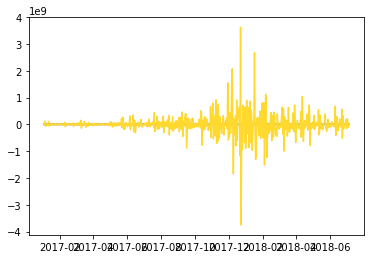

In [444]:
# 差分之后可能有0值，再标准化的时候要注意除数不为0
plt.plot(train_data)

In [445]:
from numpy import *

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def extract_window_data(df, window_len, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [446]:
target_col = 'close'

In [447]:
def prepare_data(train_data,test_data,target_col, window_len, test_size,zero_base=True):
    """ Prepare data for LSTM. """
    
    # extract window data, 并针对每一个window_len中的第一天做了变化百分比的处理
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    # y_train也是差分后的值。但是，因为差分的时候少了一行（drop了为nan的第一行）
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return X_train, X_test, y_train, y_test

In [448]:
X_train, X_test, y_train, y_test = prepare_data(
    train_data,test_data, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [491]:
X_test[0] # 也是标准化之后的值

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.21647059,  -0.33202539,  -0.7328841 ,  -1.67568232,
        -12.66166874, -13.28807038],
       [ -3.82461538,  -3.08863243,   0.61967655,  -0.17359233,
         -4.86644726,  -4.73794543],
       [ -0.08235294,  -0.6356607 ,   3.4722372 ,   0.91849029,
         -2.49300808,  -1.969482  ],
       [ -0.30244344,  -1.23369879,  -2.5787062 ,  -1.62232604,
          5.42007317,   5.66102467],
       [  5.5518552 ,   0.37899596, -10.38948787,  -1.47479715,
         15.77487429,  14.81401766],
       [ -2.5838914 ,   2.2085401 ,  -0.55660377,  -5.45008606,
        -16.15526301, -16.88616769]])

In [449]:
from keras.regularizers import L1L2
from keras import regularizers
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.25, loss='mse', optimizer='adam'):
    model = Sequential()
    print('input_data.shape'+str(input_data.shape))
    # input shape = (window length,window length - 1)
    # input shape tutorial: https://yq.aliyun.com/articles/194956
    model.add(LSTM(neurons,input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
#     model.add(Dense(units=output_size,kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    # adam will auto-adjust its learning rate
    model.compile(loss=loss, optimizer=optimizer)
    return model

Ideally a batch size of 1 would be used for walk-foward validation. We will assume **walk-forward validation** and predict the whole year for speed. As such we can use any batch size that is **divisble** by the number of samples, in this case we will use a value of 4. 

Keras不会自动处理无法整除的batch吗？

In [450]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.2
zero_base = True

# model params
lstm_neurons = 100
epochs = 50
batch_size = 4
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [479]:
testStationarity(train['close'])

Test Statistic                  -1.557418
p-value                          0.504941
#Lags Used                      19.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64

In [459]:
X_train[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.28369231e+00,  2.88337731e+01, -3.30679731e-02,
        -2.48033318e-01, -1.09850408e+01, -1.25048655e+01],
       [-9.98830769e+00, -4.48548813e-01, -1.00502143e+01,
         3.72512726e+00, -9.23876434e+00, -8.46112890e+00],
       [-7.35015385e+00, -3.35092348e+01, -2.34598898e+00,
        -7.75890791e+00,  3.49809025e+00,  5.59940551e+00],
       [-8.33230769e-01, -3.43931398e+01, -3.81016534e+00,
        -5.77510412e+00,  5.26035507e+00,  5.64407062e+00],
       [-2.62153846e-01,  8.30606860e+00,  3.23698714e+00,
        -8.74595095e-01,  4.28916862e+00,  3.29444545e+00],
       [-1.06646154e+00, -7.77044855e+00, -1.30251072e+00,
        -4.45164276e-01,  4.09585364e-01,  4.40390606e-01]])

In [460]:
y_train[0]

-0.7175384615384596

**以上，都是已经difference and normalize的**

In [452]:
from keras.callbacks import EarlyStopping
from keras import optimizers

# patience=2: 两次loss连续上升就会停止
early_stopping = EarlyStopping(monitor='loss', patience=2)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, 
                         dropout=dropout, loss=loss)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=4,verbose=1, shuffle=True, callbacks=[early_stopping])

input_data.shape(541, 7, 6)
Epoch 1/50
541/541 [==============================] - 4s 8ms/step - loss: 286.8662
Epoch 2/50
541/541 [==============================] - 1s 3ms/step - loss: 281.2734
Epoch 3/50
541/541 [==============================] - 1s 3ms/step - loss: 274.7199
Epoch 4/50
541/541 [==============================] - 1s 3ms/step - loss: 268.1841
Epoch 5/50
541/541 [==============================] - 1s 3ms/step - loss: 261.2218
Epoch 6/50
541/541 [==============================] - 1s 3ms/step - loss: 250.9228
Epoch 7/50
541/541 [==============================] - 1s 3ms/step - loss: 244.1785
Epoch 8/50
541/541 [==============================] - 1s 3ms/step - loss: 238.1624
Epoch 9/50
541/541 [==============================] - 1s 3ms/step - loss: 225.5946
Epoch 10/50
541/541 [==============================] - 1s 3ms/step - loss: 220.5452
Epoch 11/50
541/541 [==============================] - 1s 3ms/step - loss: 212.2238
Epoch 12/50
541/541 [==============================] - 2s

In [513]:
preds = model.predict(X_test).squeeze()
preds.shape

(129,)

In [514]:
# 乘以差分值，将他反norm
preds[:5]

array([-0.8245396 ,  0.24193364, -0.7243242 , -0.47761047, -1.0156244 ],
      dtype=float32)

In [515]:
testStationarity(preds) # stationary. -10<-3

Test Statistic                -1.171557e+01
p-value                        1.454041e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64

In [501]:
test[target_col].values[:-window_len-1].shape

(129,)

In [520]:
# inverse normalization: diff * (preds+1)
diff_test = difference(test[target_col])
diff_test[:5]

time
2018-07-05    -55.25
2018-07-06     67.21
2018-07-07    156.06
2018-07-08    -50.70
2018-07-09    -38.54
Name: close, dtype: float64

In [522]:
diff_test.shape

(136,)

In [524]:
preds = (diff_test[window_len:]) * (preds + 1)
preds.shape
# 得到正常的差分值

(129,)

In [525]:
# inverse difference
xi = []
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = []
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [526]:
train,test = train_test_split(hist, test_size=0.2)
test.iloc[0,0]

6590.06

In [556]:
last_ob = test.iloc[:,0]
last_ob

time
2018-07-04    6590.06
2018-07-05    6534.81
2018-07-06    6602.02
2018-07-07    6758.08
2018-07-08    6707.38
2018-07-09    6668.84
2018-07-10    6306.85
2018-07-11    6394.36
2018-07-12    6253.60
2018-07-13    6229.83
2018-07-14    6268.75
2018-07-15    6364.26
2018-07-16    6740.55
2018-07-17    7326.70
2018-07-18    7383.39
2018-07-19    7477.50
2018-07-20    7333.93
2018-07-21    7405.40
2018-07-22    7398.64
2018-07-23    7718.00
2018-07-24    8395.82
2018-07-25    8170.23
2018-07-26    7937.25
2018-07-27    8182.89
2018-07-28    8230.87
2018-07-29    8216.78
2018-07-30    8176.06
2018-07-31    7735.30
2018-08-01    7610.90
2018-08-02    7542.34
               ...   
2018-10-19    6469.28
2018-10-20    6490.56
2018-10-21    6509.87
2018-10-22    6483.23
2018-10-23    6470.22
2018-10-24    6476.25
2018-10-25    6462.77
2018-10-26    6457.21
2018-10-27    6470.17
2018-10-28    6470.74
2018-10-29    6313.91
2018-10-30    6309.11
2018-10-31    6342.61
2018-11-01    6381.30
2018-

In [557]:
preds

time
2018-07-12      3335.703123
2018-07-13       677.938496
2018-07-14       456.504399
2018-07-15      4860.830938
2018-07-16     -1836.034417
2018-07-17     49773.484463
2018-07-18      2523.024400
2018-07-19     19248.817422
2018-07-20    243243.688105
2018-07-21    -19975.031823
2018-07-22       111.440195
2018-07-23    -12541.930714
2018-07-24    197833.378912
2018-07-25    -42751.463879
2018-07-26    108502.874035
2018-07-27      4787.770675
2018-07-28      2379.891696
2018-07-29     -8087.116468
2018-07-30      2404.246641
2018-07-31     37695.285690
2018-08-01    -15543.207451
2018-08-02      1891.619841
2018-08-03    -65296.464538
2018-08-04   -247164.162198
2018-08-05      2678.457700
2018-08-06      2932.034423
2018-08-07     31124.979482
2018-08-08     36381.670913
2018-08-09    129602.580013
2018-08-10    302434.720613
                  ...      
2018-10-19         8.104562
2018-10-20       -32.003686
2018-10-21       797.632265
2018-10-22      1696.121189
2018-10-23     

In [558]:
inverted = inverse_difference(last_ob, preds)
inverted[5]
#2018-07-04

time
2018-07-04    63858.487002
2018-07-05    63803.237002
2018-07-06    63870.447002
2018-07-07    64026.507002
2018-07-08    63975.807002
2018-07-09    63937.267002
2018-07-10    63575.277002
2018-07-11    63662.787002
2018-07-12    63522.027002
2018-07-13    63498.257002
2018-07-14    63537.177002
2018-07-15    63632.687002
2018-07-16    64008.977002
2018-07-17    64595.127002
2018-07-18    64651.817002
2018-07-19    64745.927002
2018-07-20    64602.357002
2018-07-21    64673.827002
2018-07-22    64667.067002
2018-07-23    64986.427002
2018-07-24    65664.247002
2018-07-25    65438.657002
2018-07-26    65205.677002
2018-07-27    65451.317002
2018-07-28    65499.297002
2018-07-29    65485.207002
2018-07-30    65444.487002
2018-07-31    65003.727002
2018-08-01    64879.327002
2018-08-02    64810.767002
                  ...     
2018-10-19    63737.707002
2018-10-20    63758.987002
2018-10-21    63778.297002
2018-10-22    63751.657002
2018-10-23    63738.647002
2018-10-24    63744.677

In [559]:
len(inverted)

129

In [568]:
# real values
targets = test[target_col][:-8]
targets.shape

(129,)

In [569]:
# inverted = pd.DataFrame(inverted,columns=['predicted'])
# inverted['time'] = targets.index
# inverted = inverted.set_index('time')
# inverted.head()

In [570]:
targets.head()

time
2018-07-04    6590.06
2018-07-05    6534.81
2018-07-06    6602.02
2018-07-07    6758.08
2018-07-08    6707.38
Name: close, dtype: float64

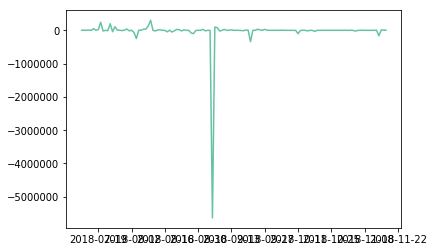

In [574]:
plt.plot(preds)

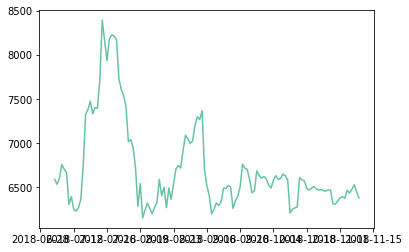

In [572]:
plt.plot(targets)

In [575]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [AUD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

In [578]:
# preds = pd.Series(index=targets.index, data=preds)
# line_plot(targets, inverted,'actual', 'prediction','7 days prediction', lw=3)

Loss is 500 -> 270 and becomes to be nan in few ms:  
- https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
- 把差分后的数据剔除0就好了。

Bias Weight/ Input Weight/ Recurrent Weight Regularization:
- https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/
- https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

dropna(inplace=True) is important.

In [275]:
type(None)

NoneType

In [276]:
from numpy import NaN
type(NaN)

float

In [291]:
type(nan)

float